# Outline

This project has several sections and  provide a concise introduction to time series concepts in R. We will learn the essential theory and also practice fitting the four main types of time series models.


(1) Time Series Data Overview (Theory)

(2) Why Time Series? (Theory)

(3) Key Concepts: Autocorrelation / Autocovariance (Theory)

(4) Key Concepts: Stationarity (Theory)

(5) Checking for Stationarity (Practice)

(6) Transforming for Stationarity: Differencing (Practice)

(7) Transforming for Stationarity: Detrending (Practice)

(8) Fitting AR / MA / ARMA / ARIMA models with the Box Jenkins Method (Theory)


# load the R packages


In [1]:
#load required r packages
library(IRdisplay)
library(magrittr)
library(tidyverse)
library(scales)
library(gridExtra)
library(forecast)
library(tseries)
library(ggthemes)
theme_set(theme_economist())

#load helper R functions
setwd("C:/Users/Administrator/Desktop/Time Series Project Materials/")
source("R Functions/compare_models_function.R")
source("R Functions/sim_random_walk_function.R")
source("R Functions/sim_stationary_example_function.R")

print("Loading is completed")

Warning message in as.POSIXlt.POSIXct(Sys.time()):
"unable to identify current timezone 'C':
please set environment variable 'TZ'"
-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v ggplot2 3.3.0     v purrr   0.3.3
v tibble  2.1.3     v dplyr   0.8.5
v tidyr   1.0.2     v stringr 1.4.0
v readr   1.3.1     v forcats 0.5.0

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x tidyr::extract()   masks magrittr::extract()
x dplyr::filter()    masks stats::filter()
x dplyr::lag()       masks stats::lag()
x purrr::set_names() masks magrittr::set_names()


Attaching package: 'scales'


The following object is masked from 'package:purrr':

    discard


The following object is masked from 'package:readr':

    col_factor



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



[1] "Loading is completed"


# Time Series Data Overview

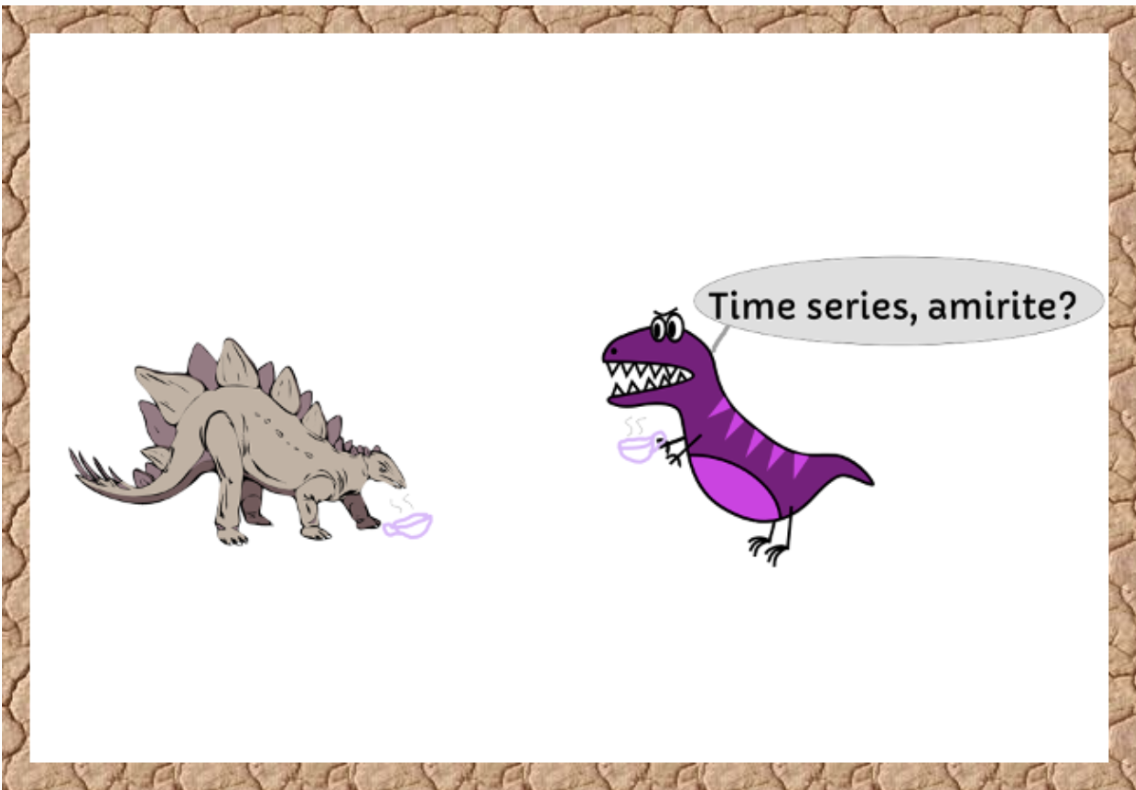

In [3]:
display_png(file="Images/time_series_dinosaur.png")

(Univariate) time series data is defined as sequence data over time: $X_1, X_2, ... , X_T$

where $t$ is the time period and $X_t$ is the value of the time series at a particular point

Examples: daily temperatures in Boston, US presidential election turnout by year, minute stock prices

Variables in time series models generally fall into three categories:

(1) endogenous

(2) random noise

(3) exogenous

All time series models involve (1) and (2) but (3) is optional.

# Why Time Series?

The answer is that:

(1) many forecasting tasks actually involve small samples which makes machine learning less effective

(2) time series models are more interpretable and less black box than machine learning algorithms

(2) time series appropriately accounts for forecasting uncertainty.

As an example, lets look at the following data generating process known as a random walk: $X_t=X_{t-1}+\epsilon_t$

We can compare the forecasting performance of linear regression to that of a basic time series model known as an AR(1) model.

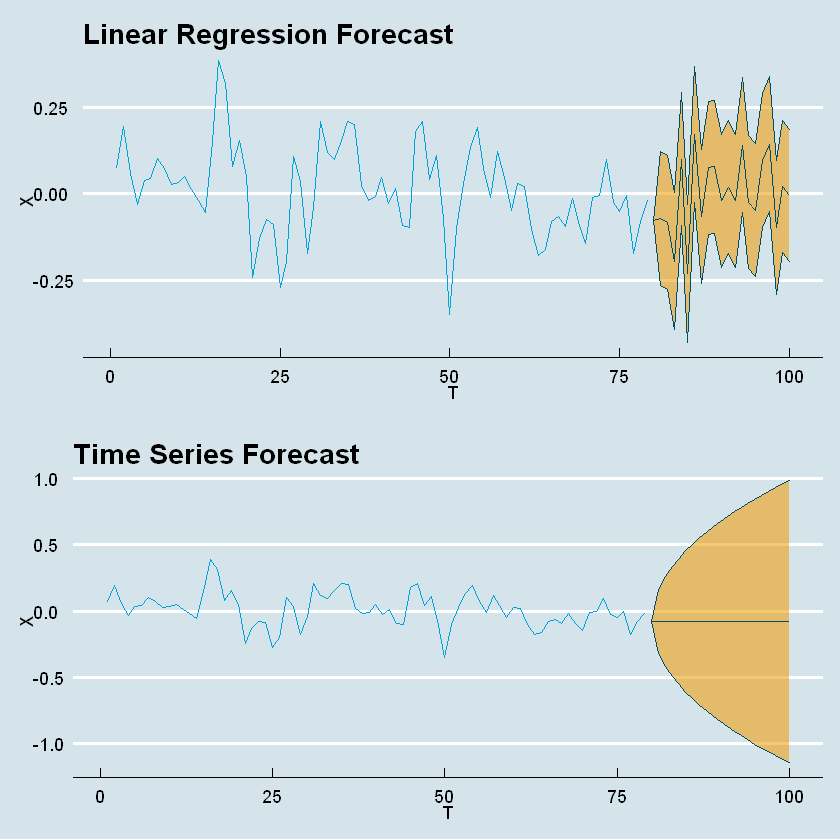

In [2]:
#run function to compare linear regression to basic AR(1) time series model
compare.models(n=100)
# the light blue is going to be the past simualted data and the dark blue is the forecast from each model
# and in orange we are going to have the confidence intervals

the linear regression forcast dosen't account what's known as compound error 
where because we making successful feature prediction the confidence interval width should increase over time.
The linear regression forcast also overfit the past observations pattern of the data.
The time series model does a much better job.


# Key Concepts: Autocorrelation/Autocovariance

Autocorrelation/autocovariance refers to the correlation/covariance between two observations in the time series at different points.

The central idea behind it is how related the data/time series is over time.

For ease of interpretation we typically focus on autocorrelation i.e. what is the correlation between $X_t$ and $X_{t+p}$ for some integer $p$.

A related concept is partial autocorrelation that computes the correlation adjusting for previous lags/periods i.e. the autocorrelation between $X_t$ and $X_{t+p}$ adjusting for the correlation of $X_t$ and $X_{t+1}$, … , $X_{t+p-1}$.

When analyzing time series we usually view autocorrelation/partial autocorrelation in ACF/PACF plots.

Let's view this for the random walk model we analyzed above: $X_t=X_{t-1}+\epsilon_t$.

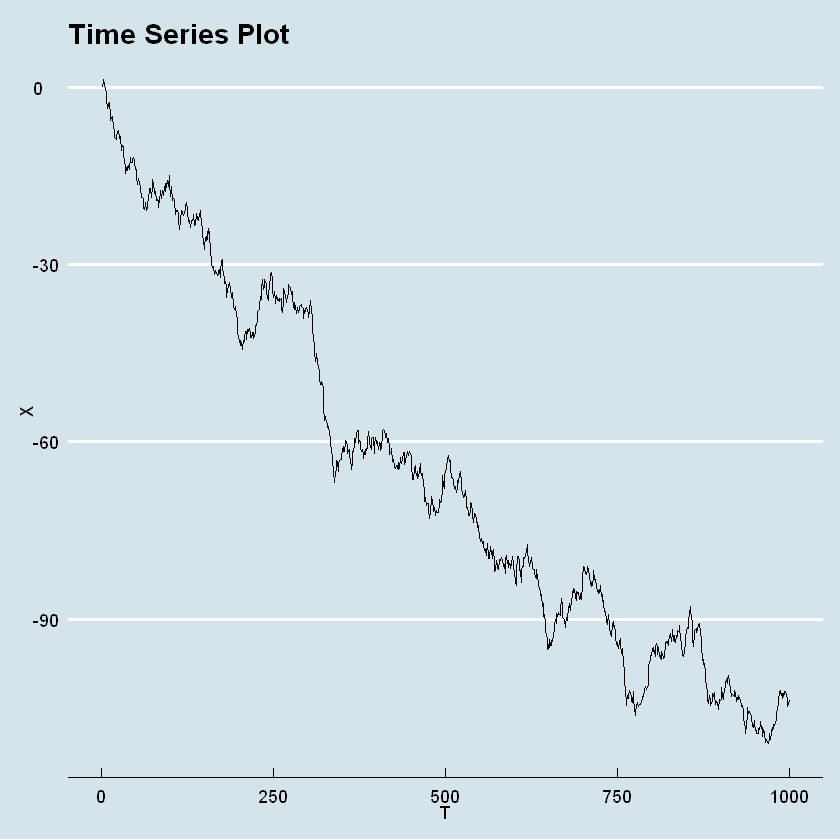

In [3]:
#simulate random walk
dat<-sim.random.walk()

#plot random walk
dat %>% ggplot(aes(t,X)) + geom_line() + xlab("T") + ylab("X") + ggtitle("Time Series Plot")

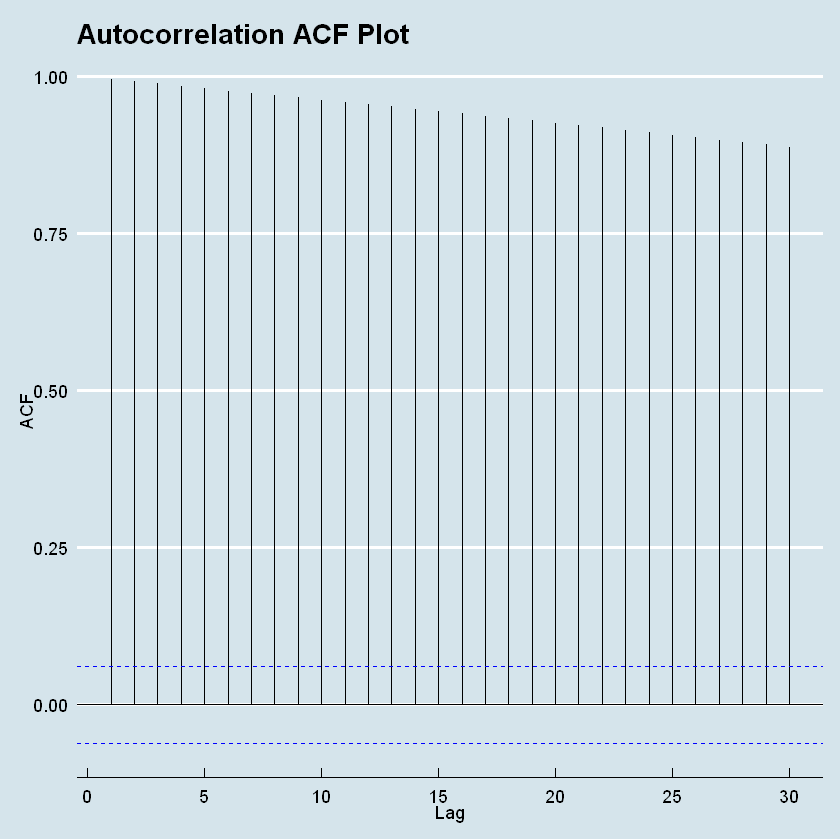

In [4]:
#ACF plot
ggAcf(dat$X,type="correlation") + ggtitle("Autocorrelation ACF Plot")

From the ACF plot , there is a high degree of correlation between lags and time series .
gradually decreasing over time but stays high.

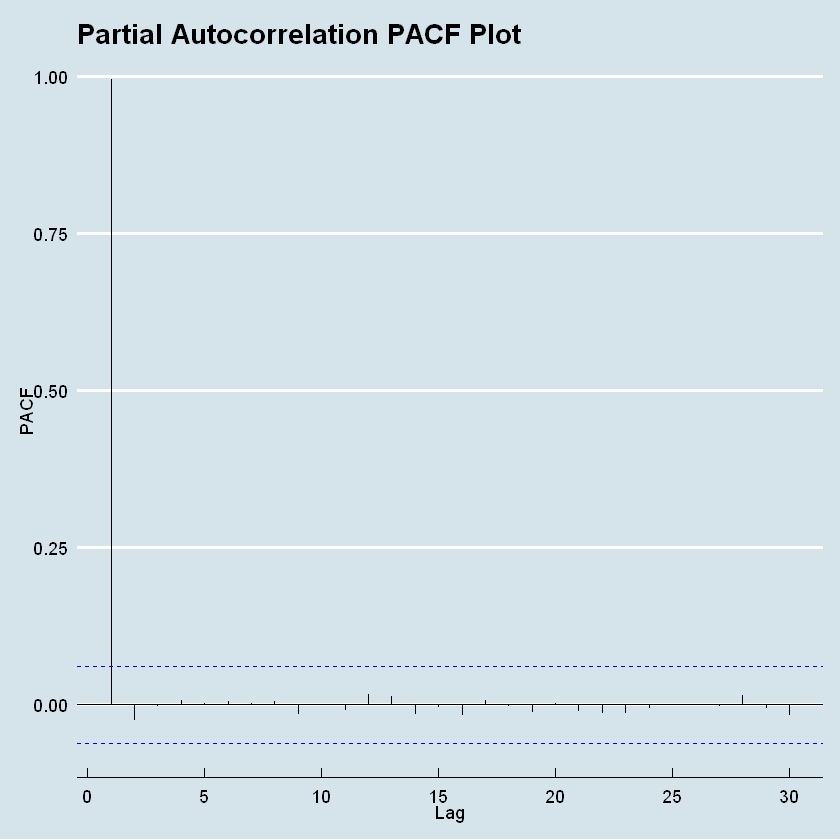

In [5]:
#PACF plot
ggAcf(dat$X,type="partial") + ggtitle("Partial Autocorrelation PACF Plot")

 The PACF plot show there is a high degree of correlation between time periods an on lag apart.
this means the longer time lag are not significantly related to one another.

# Key Concepts: Stationarity

The second key concept in time series is stationarity.

While the concept can get quite technical, the basic idea is examining whether the distribution of the data over time is consistent.

There are two main forms of stationarity.

(1) Strict stationarity imples:

The cumulative distribution function of the data does not depend on time:

$F_X(X_1,...,X_T)=F_X(X_{1+\Delta},...,X_{T+\Delta})$ $\forall \Delta\in\mathbb{R}$ 

(2) Weak stationarity implies:

- the mean of the time series is constant

$E(X_t)=E(X_{t+\Delta})$

- the autocovariance/autocorrelation only depends on the time difference between points

$ACF(X_{t},X_{t+\Delta-1})=ACF(X_1,X_{\Delta})$

- the time series has a finite variance

$Var(X_\Delta)<\infty$  $\forall \Delta\in\mathbb{R}$

# Checking for Stationarity

In [13]:
#create three time series for example
df<-sim.stationary.example(n=1000)
head(df); dim(df)                       

,t,X1,X2,X3
,<int>,<dbl>,<dbl>,<dbl>
1,1,-1.41593175,1.232265,-0.57911839
2,2,-0.45165503,1.862427,0.73635771
3,3,-0.17808593,2.365499,-0.02213683
4,4,-0.37370242,4.151522,0.31465905
5,5,0.01804675,5.584858,1.83460950
6,6,-0.08911285,5.117270,0.82096483


[1] 1000    4

The first way is :
- Check a plot of the time series over time and look for constant mean and finite variance i.e. values appear bounded.

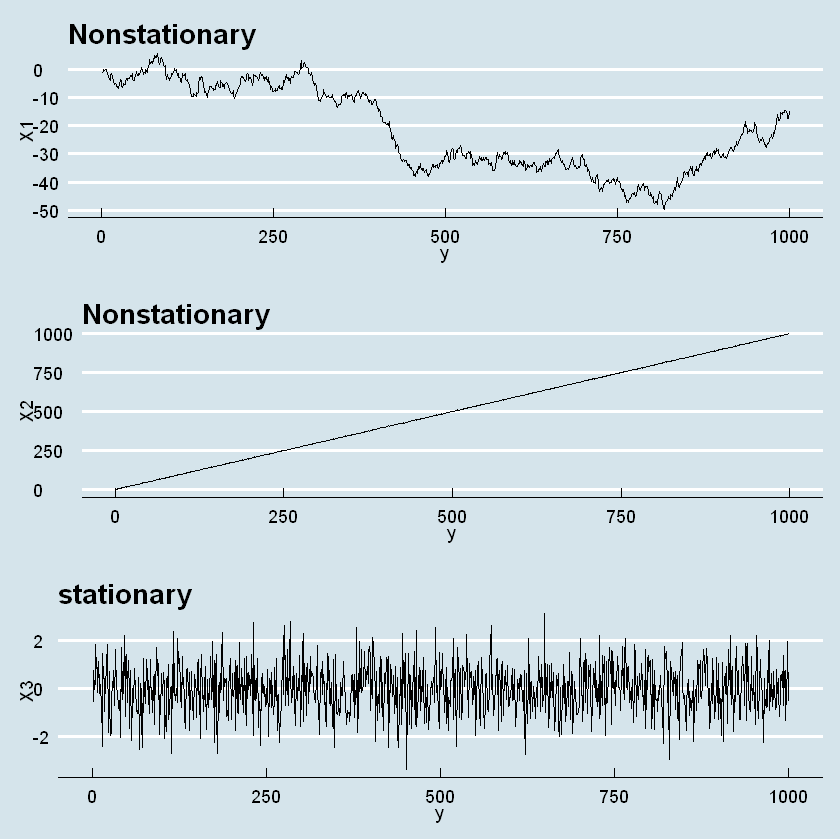

In [14]:
#plot nonstationary and stationary time series
g1<- ggplot(df,aes(x=t,y=X1))+ geom_line()+xlab("y")+ylab("X1")+ggtitle("Nonstationary")
g2<- ggplot(df,aes(x=t,y=X2))+ geom_line()+xlab("y")+ylab("X2")+ggtitle("Nonstationary")
g3<- ggplot(df,aes(x=t,y=X3))+ geom_line()+xlab("y")+ylab("X3")+ggtitle("stationary")
grid.arrange(g1,g2,g3)

In nonstationary,the mean dosen't look constant it changes  through successive periods and the values
don't apear super well boundedand it definetly doesn't have finite variance
but in stationary  time series has a constant mean  throughout time and very well bounded values and it definetly have finite variance.


The second way is:
- Look at the ACF plot and see if it dies off quickly as opposed to a gradual decline.

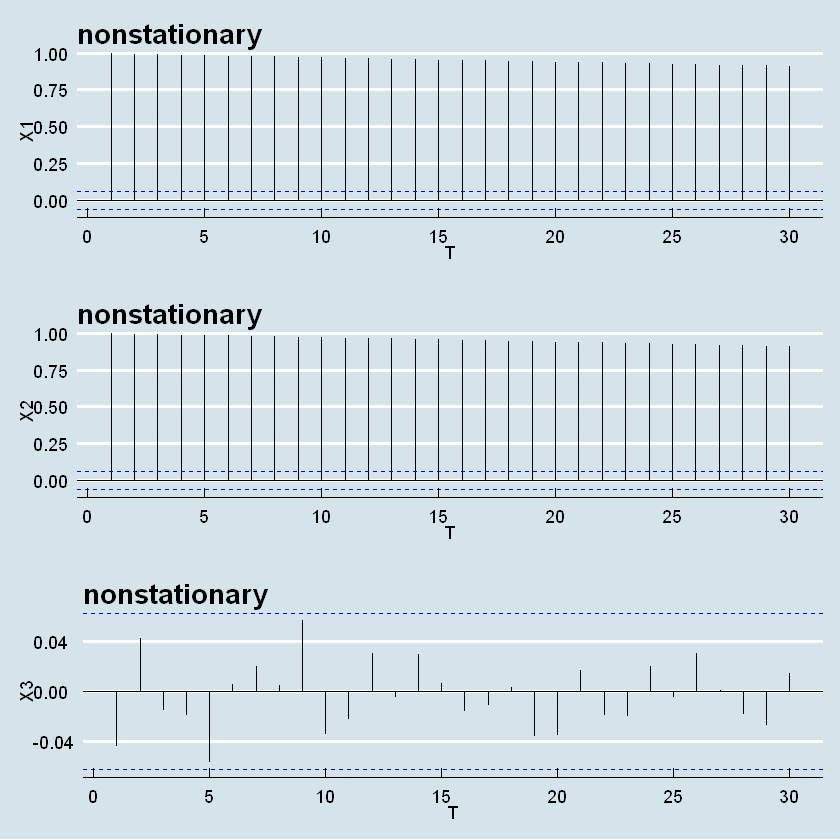

In [18]:
#ACF for nonstationary and stationary time series
g1<- ggAcf(df$X1,type="correlation") + xlab("T" ) +ylab("X1") + ggtitle("nonstationary")

g2<- ggAcf(df$X2,type="correlation")+xlab("T")+ylab("X2") + ggtitle("nonstationary")
g3<- ggAcf(df$X3,type="correlation")+xlab("T")+ylab("X3")+ ggtitle("nonstationary")
grid.arrange(g1,g2,g3)

In nonstatinary time series plot , we can see that auto correlation dosen't die of quiockly and go to zero.
Instead is very high across the large number of lags in time series.
In stationary time series plot,shows almost all signifcant auto correlation across lags in timeseries


Third way:
- Perform unit root tests such as the Augmented Dickey–Fuller test.

In [20]:
#perform unit test; nonstationary example has large, non-significant p-value
adf.test(df$X1)


Warning message in adf.test(df$X1):
"p-value greater than printed p-value"



	Augmented Dickey-Fuller Test

data:  df$X1
Dickey-Fuller = -0.29837, Lag order = 9, p-value = 0.99
alternative hypothesis: stationary


In [21]:
#perform unit test; stationary example has small, significant p-value
adf.test(df$X3)

Warning message in adf.test(df$X3):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  df$X3
Dickey-Fuller = -10.014, Lag order = 9, p-value = 0.01
alternative hypothesis: stationary


# Transforming for Stationarity

## Differencing

Differencing involves taking differences between successive time series values.

The order of differencing is defined as p for $X_t-X_{t-p}$.

Let's transform a nonstationary time series to stationary by differencing with the random walk model.

In a random walk $X_t=X_{t-1}+\epsilon_t$ where $\epsilon_t\sim N(0,\sigma^2)$ iid.

Differencing with an order of one means that $\tilde{X}_t=X_t-X_{t-1}=\epsilon_t$.

In [26]:
#difference time series to make stationary
diff<- df$X1- lag(df$X1,1)

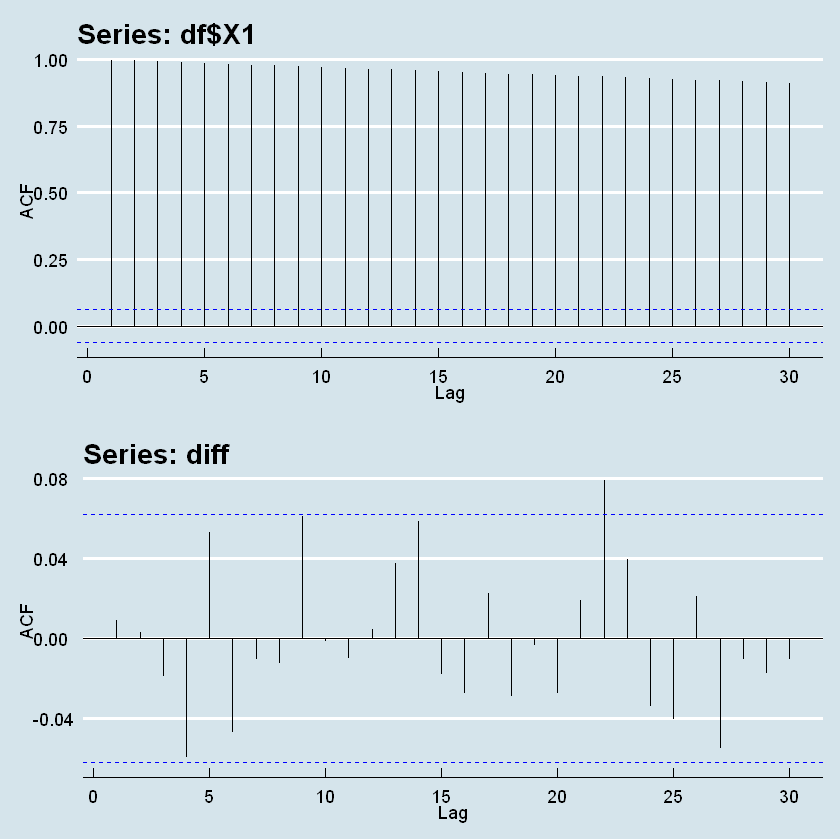

In [27]:
#plot original and differenced time series
g1<- ggAcf(df$X1,type="correlation") 
g2<- ggAcf(diff,type="correlation") 
grid.arrange(g1,g2)


In nonstatinary time series plot , we can see that auto correlation plot dosen't off die quickly  and that the behaviour of nonstationary time series. and in the transformed time series data , we have acf plot with almost no significant autocorrelation lags.

## Detrending
another way to transform  non stationary to stationary

Detrending involves removing a deterministic relationship with time.

As an example suppose we have the following data generating process $X_t=B_t+\epsilon_t$ where $\epsilon_t\sim N(0,\sigma^2)$ iid.

Detrending involves using the transformed time series $\tilde{X}_t=X_t-Bt=\epsilon_t$.

In [28]:
#detrend time series to make stationary
detrended <- resid(lm(X2~t,data=df))

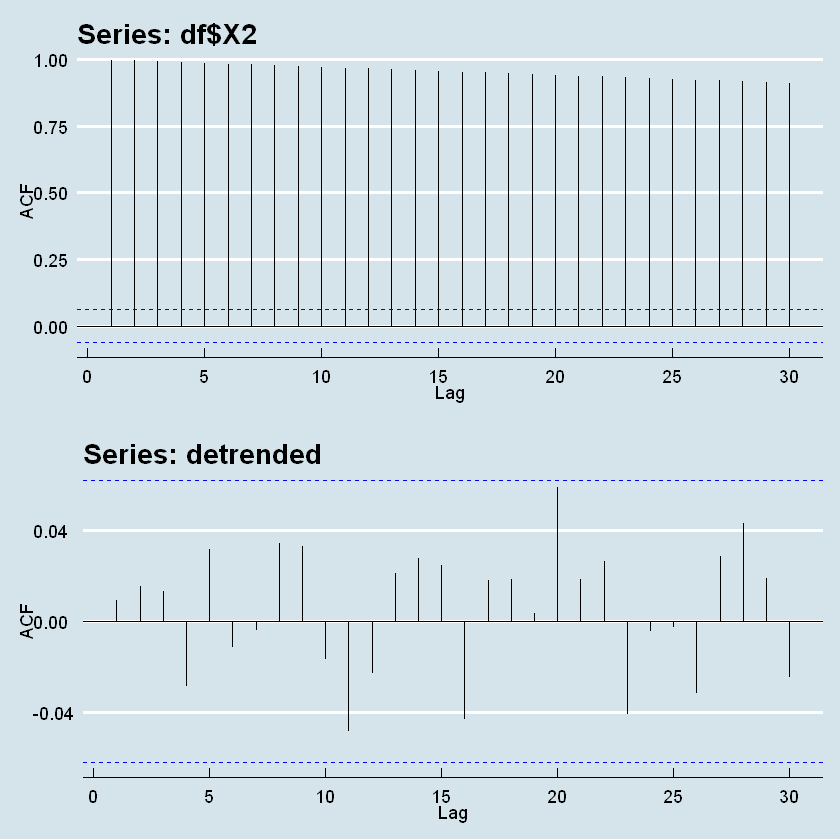

In [29]:
#plot original and detrended time series
g1 <- ggAcf(df$X2,type="correlation")
g2<- ggAcf(detrended,type ="correlation")
grid.arrange(g1,g2)

The detrending using linear regression work to transform out time series from non stationary to sationary.

# Basic Model Types: AR(p), MA(q), ARMA(p,q), ARIMA(p,d,q), Decomposition

## Autoregressive AR(p) Models

AR models specify $X_t$ as a function of lagged time series values $X_{t-1}$, $X_{t-2}$, ...

i.e $X_t=\mu+\phi_1 X_{t-1}+...+\phi_p X_{t-p}+\epsilon_t$

where $\mu$ is a mean term and $\epsilon_t\overset{iid}\sim N(0,\sigma^2)$ is a random error.

When fitting an AR model the key choice is p, the number of lags to include.

## Moving Average MA(q) Models

MA models specify $X_t$ using random noise lags:

$X_t=\mu+\epsilon_t+\Theta_1\epsilon_{t-1}+...+\Theta_q\epsilon_{t-q}$

where $\mu$ is a mean term and $\epsilon_t\overset{iid}\sim N(0,\sigma^2)$ is a random error.

Similar to an AR model, when fitting an MA model the key choice is q, the number of random shock lags.

## Autoregressive Moving Average ARMA(p,q) Models

ARMA(p,q) models are a combination of an AR and MA model:

$X_t=\mu+\phi_1 X_{t-1}+...+\phi_p X_{t-p}+\epsilon_t+\Theta_1\epsilon_{t-1}+...+\Theta_q\epsilon_{t-q}$

where $\mu$ is a mean term and $\epsilon_t\overset{iid}\sim N(0,\sigma^2)$ is a random error.

When fitting an ARMA model, we need to choose two things: p, the number of AR lags, and q, the number of MA lags.

## Autoregressive Integrated Moving Average ARIMA(p,d,q) Models

ARIMA(p,d,q) is an ARMA model with differencing.

When fitting an ARIMA model we need to choose three things: p, the number of AR lags, q, the number of MA lags, and d, the number of differences to use.

## Decomposition Models

Decomposition models specify $X_t$ as a combination of a trend component ($T_t$), seasonal component ($S_t$), and an error component/residual ($E_t$) i.e. $X_t=f(T_t,S_t,E_t)$.

Common decomposition forms are: $X_t=T_t+S_t+E_t$ or $X_t=T_t*S_t*E_t$ (where then take logs to recover the additive form).

There are various ways to estimate the different trend components: exponential smoothing, state space models/Kalman filtering, STL models, etc.

In this project we will cover STL models because of their ease of use and flexibility.

# Fitting AR/MA/ARMA/ARIMA models with the Box Jenkins Method

We will now go over how to fit AR/MA/ARMA/ARIMA models on a real data set and review a generic strategy for fitting them known as the Box Jenkins method. 

This process involves several steps to help identify the p, d, and q parameters that we need:

- Identify whether the time series is stationary or not

- Identify p, d, and q of the time series by

  - Making the the time series stationary through differencing/detrending to find d
  
  - Looking at ACF/PACF to find p and q
  
  - Using model fit diagnostics like AIC or BIC to select the best model to find p, d, and q

- Check the model fit using the Ljung–Box test

In [2]:
#load data
df <- read.csv("Data/Mass Monthly Unemployment Rate.csv")
head(df); dim(df)

,DATE,MAURN
,<fct>,<dbl>
1,1976-01-01,11.6
2,1976-02-01,11.3
3,1976-03-01,10.9
4,1976-04-01,9.9
5,1976-05-01,9.4
6,1976-06-01,9.8


[1] 529   2

This dataset contains two columns and 529 rows. The first column is the date column and the second one is the monthly unemplyment rate.

In [3]:
#check date class
class(df$DATE)

[1] "factor"

The date column type isn't date class instead its a factor class.So,I will transform the date class to date type.

In [4]:
#change date class to date type
df$DATE<-as.Date(df$DATE)

In [5]:
#check date class
class(df$DATE)

[1] "Date"

## Checking for Stationarity

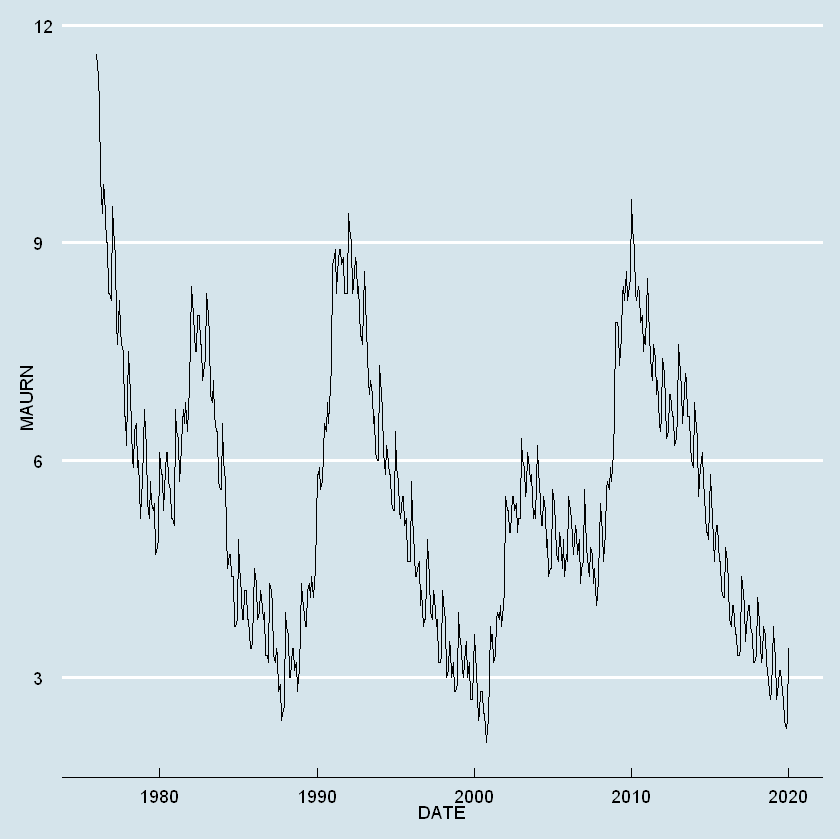

In [7]:
#check time series plot
ggplot(df,aes(x=DATE,y=MAURN))+geom_line()

From the above plot, We can see that generally the values doesn't apear super well bounded and the mean dosen't apear constant over time. And this a strong evidence that this time series data isn't stationary.

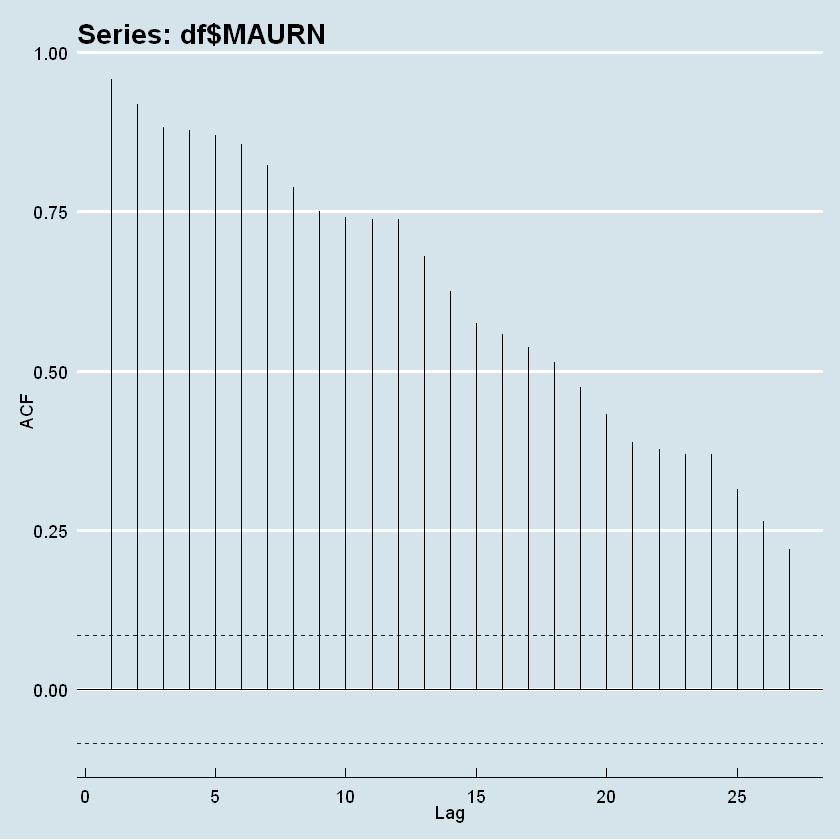

In [8]:
#check ACF plot
ggAcf(df$MAURN,type ="correlation")

 we can see that ACF plot  dosen't die of quickly and go to zero. Instead is very high across the large number of lags in time series. again that a strong evidence that the time series data is nonstationary.

In [9]:
#run ADF test
adf.test(df$MAURN)


	Augmented Dickey-Fuller Test

data:  df$MAURN
Dickey-Fuller = -3.0954, Lag order = 8, p-value = 0.1146
alternative hypothesis: stationary


p-vlaue > 0.05 so we accept the null hypothesis that said the series is nonstationary.

we know  now that the series is non stationary so we need to transform it.

## Transforming for Stationarity & Identifying Model Parameters

In [12]:
#fit AR model
ar.model <- auto.arima(df$MAURN,max.d=0,max.q=0,allowdrift=T)
ar.model

Series: df$MAURN 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
         ar1    mean
      0.9787  5.7425
s.e.  0.0101  0.8498

sigma^2 estimated as 0.2:  log likelihood=-325.44
AIC=656.88   AICc=656.93   BIC=669.7

In [13]:
#fit MA model
ma.model <- auto.arima(df$MAURN,max.d=0,max.p=0,allowdrift=T)

ma.model

Series: df$MAURN 
ARIMA(0,0,5) with non-zero mean 

Coefficients:
         ma1     ma2     ma3     ma4     ma5    mean
      1.3646  1.7103  1.4882  1.2714  0.4804  5.4588
s.e.  0.0368  0.0492  0.0578  0.0393  0.0350  0.1507

sigma^2 estimated as 0.229:  log likelihood=-361.03
AIC=736.05   AICc=736.27   BIC=765.95

In [14]:
#fit ARMA model
arma.model <- auto.arima(df$MAURN,max.d=0,allowdrift=T)
arma.model

Series: df$MAURN 
ARIMA(3,0,2) with non-zero mean 

Coefficients:
          ar1     ar2     ar3     ma1     ma2    mean
      -0.2266  0.5998  0.5573  1.3361  0.8876  5.7038
s.e.   0.0885  0.0544  0.0569  0.0544  0.0221  0.7763

sigma^2 estimated as 0.1693:  log likelihood=-280.15
AIC=574.3   AICc=574.51   BIC=604.19

In [15]:
#fit ARIMA model
arima.model <- auto.arima(df$MAURN,allowdrift=T)
arima.model

Series: df$MAURN 
ARIMA(4,1,2) 

Coefficients:
         ar1      ar2      ar3     ar4      ma1     ma2
      1.0029  -0.1834  -0.3982  0.4872  -1.1149  0.2512
s.e.  0.0708   0.0750   0.0560  0.0394   0.0793  0.0711

sigma^2 estimated as 0.1509:  log likelihood=-247.45
AIC=508.9   AICc=509.12   BIC=538.78

# Where to go Next

- Advanced time series models
  - ARCH, GARCH, etc. that model changing variance over time
- Vector Autoregression (VAR)
  - For multivariate i.e. multiple time series and modeling dependencies between them
- Machine Learning
  - How to do CV with time series
  - Neural networks for sequence data (LSTMs, etc.)
- Spatial Statistics
  - Generalize time dependence to spatial dependence in multiple dimensions
- Econometrics
  - Cointegration
  - Granger Causality
  - Serial correlation
  - Regression with time series data
- Bayesian time series